# Germany power consumption time series 

## Main objective

Perform a Time Series analysis using SARIMA-ARIMA models, to identify and forecasting the weekly power consumption patterns in Germany.

Author: Luis Fernando Salazar Salinas Date: 22/07/2021

In [1]:
## Libraries 
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore')
import seaborn as sns
from colorsetup import colors, palette
plt.style.use('fivethirtyeight')
sns.set_palette(palette)
import pandas as pd
from datetime import datetime
import statsmodels.api as sm
import pmdarima as pm

## Germany Power Consumption dataset
Data source:https://cutt.ly/1QMm1uM
License: (CC0: Public Domain)

In [2]:
## import dataset
datafile = " ./Germany Power Consumption.csv"
Gr_e = pd.read_csv(datafile)

## Preprocessing and EDA

In [3]:
## Overview information of data
Gr_e.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48934 entries, 0 to 48933
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   start   48934 non-null  object 
 1   end     48934 non-null  object 
 2   load    48934 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [4]:
## Overview information of data (five first rows)
Gr_e.head()

,start,end,load
0,2015-01-01 00:00:00+00:00,2015-01-01 01:00:00+00:00,3211.0
1,2015-01-01 01:00:00+00:00,2015-01-01 02:00:00+00:00,3100.0
2,2015-01-01 02:00:00+00:00,2015-01-01 03:00:00+00:00,2980.0
3,2015-01-01 03:00:00+00:00,2015-01-01 04:00:00+00:00,2933.0
4,2015-01-01 04:00:00+00:00,2015-01-01 05:00:00+00:00,2942.0


In [5]:
#Statistics summary
Gr_e.describe()

,load
count,48934.000000
mean,3767.448114
std,741.151161
min,1693.000000
25%,3164.000000
50%,3734.000000
75%,4353.000000
max,9618.000000


In [6]:
## Removing start column 
Gr_e.drop(['start'], axis= 1, inplace= True)

In [7]:
## Rename columns
Gr_e = Gr_e.rename(columns={'end':'Date'})
Gr_e = Gr_e.rename(columns={'load':'Consumption_MW'})

In [8]:
##Convert to data time
Gr_e['Date'] = pd.to_datetime(Gr_e.Date)
Gr_e.index= Gr_e['Date']

In [9]:
## sort indexs 
Gr_e = Gr_e.sort_index(ascending=True,axis=0) 
print(Gr_e['Consumption_MW'])

Date
2015-01-01 01:00:00+00:00    3211.0
2015-01-01 02:00:00+00:00    3100.0
2015-01-01 03:00:00+00:00    2980.0
2015-01-01 04:00:00+00:00    2933.0
2015-01-01 05:00:00+00:00    2942.0
                              ...  
2020-07-31 20:00:00+00:00    3353.0
2020-07-31 21:00:00+00:00    3242.0
2020-07-31 22:00:00+00:00    3015.0
2020-07-31 23:00:00+00:00    2813.0
2020-08-01 00:00:00+00:00    2695.0
Name: Consumption_MW, Length: 48934, dtype: float64


In [10]:
## Removing Date column 
Gr_e.drop(['Date'], axis= 1, inplace= True)

### Resampling time-frequency

In [11]:
##Resampling by changing frequency directly asfreq method
#### Resampling to hours frequency
Gr_e_h = Gr_e.asfreq('h')
## Resampling to daily frequency
Gr_e_d = Gr_e.asfreq('D')
## Resampling to weekly frequency
Gr_e_w  = Gr_e.asfreq('W')
# This will generate missing values:
Gr_e_w.head()

,Consumption_MW
Date,
2015-01-04 01:00:00+00:00,3058.0
2015-01-11 01:00:00+00:00,3221.0
2015-01-18 01:00:00+00:00,3058.0
2015-01-25 01:00:00+00:00,3147.0
2015-02-01 01:00:00+00:00,3108.0


#### Observation.

- In this project, we work with a weekly time-frequency.

In [12]:
## missing values from the daily consumption
Gr_e_w.isnull().sum().to_frame()

,0
Consumption_MW,0


### Power consumption in the last 70 weeks

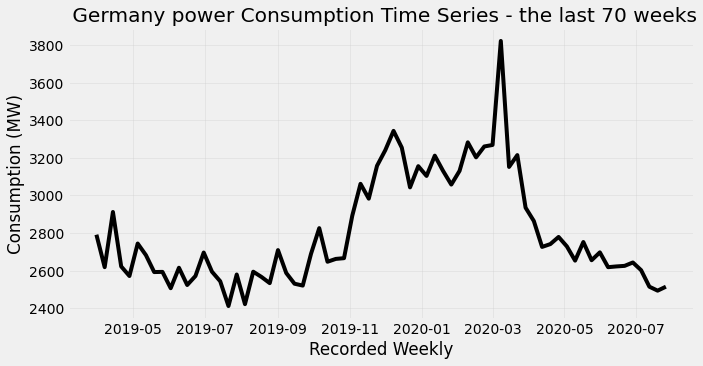

In [13]:
### Power consumption in the last 91 days (13 weeks) 
n_weeks = 70 
plt.figure(figsize=(10,5))   
plt.plot((Gr_e_w['Consumption_MW'][-n_weeks:]),'k-')
plt.title(' Germany power {} Time Series - the last {} weeks'.format('Consumption',n_weeks))
plt.xlabel('Recorded Weekly')
plt.ylabel('Consumption (MW)')
plt.grid(alpha=0.3)

#### Observations.

- In this plot, we can see how changes the consumption pattern in the last 70 weeks in Germany. this pattern trend to rise between later 2019  and early 2020, with a peak consumption maximum in March 2020. This peak can be an anomaly in the consumption due to Covid-19 pandemic.

### Sequential plots

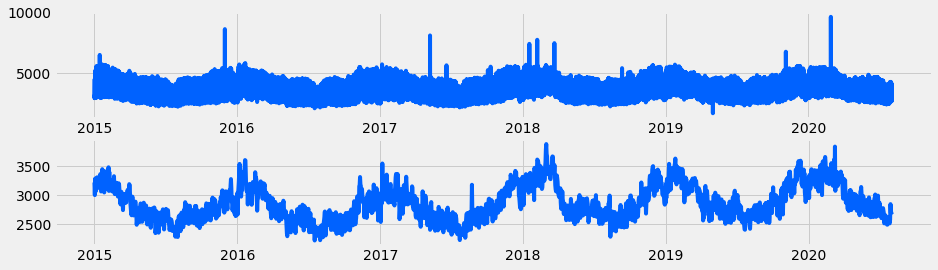

In [14]:
## plot for hours and daily of conmsuption in Germany
plt.rcParams['figure.figsize'] = [14, 4]
fig, axes = plt.subplots(2,1)
axes[0].plot(Gr_e_h)
axes[1].plot(Gr_e_d)

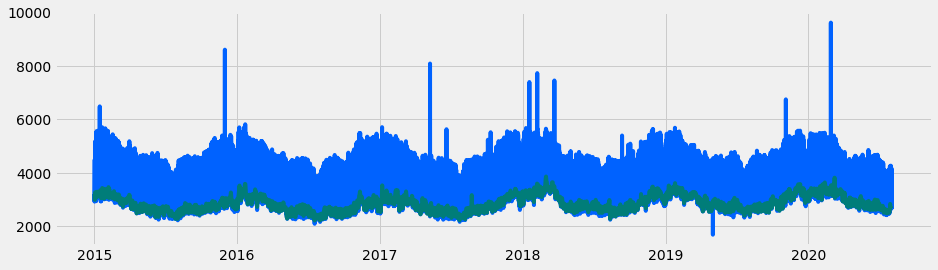

In [15]:
# plot both on same figure
plt.plot(Gr_e_h)
plt.plot(Gr_e_d)
plt.grid(b=True);

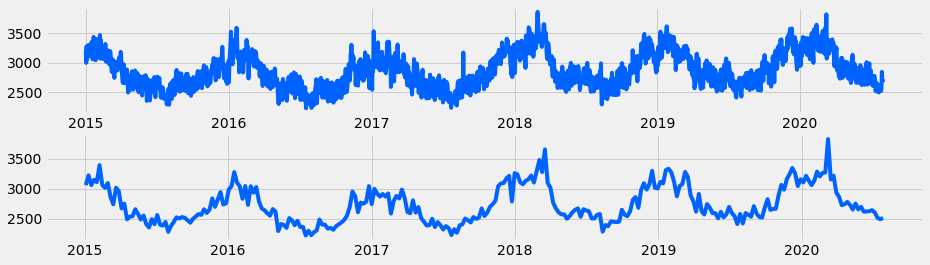

In [16]:
## plot daily and weekly of conmsuption in Germany
plt.rcParams['figure.figsize'] = [14, 4]
fig, axes = plt.subplots(2,1)
axes[0].plot(Gr_e_d)
axes[1].plot(Gr_e_w)

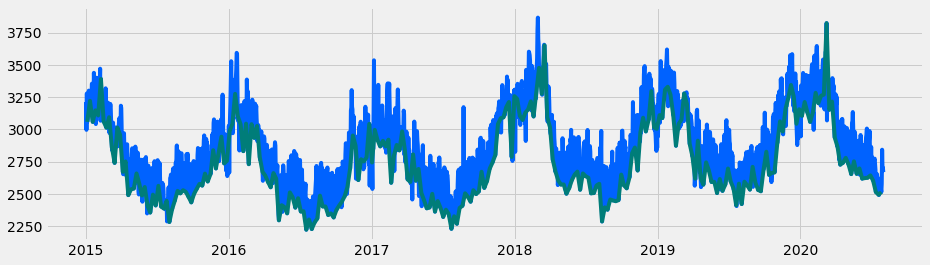

In [17]:
# plot both on same figure
plt.plot(Gr_e_d)
plt.plot(Gr_e_w)
plt.grid(b=True);

### Diskey-Fuller Test (DFT) function and Rolling Mean chart
- H0 : no-stationary serie (there is a unit root) 
- H1 : Stationary serie 

In [18]:

import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries,)
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.grid()
    plt.show(block=False)

Test Statistic           -5.195974
p-value                   0.000009
Lags Used                15.000000
Observations Used       275.000000
Critical Value (1%)      -3.454355
Critical Value (5%)      -2.872108
Critical Value (10%)     -2.572401
dtype: float64


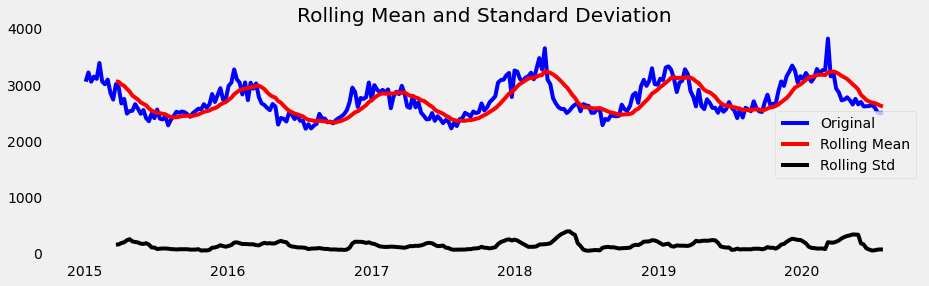

In [19]:
# run DFT on daily
dftest(Gr_e_w.Consumption_MW)

#### Observations.

- According to the p-value(<0.05), there is enough statistical evidence to reject a unit root or the null hypothesis. Therefore, this time series is stationary.

In [20]:
# Helper plot function for visualization
def plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    raw.plot(data)
    sm.tsa.graphics.plot_acf(data, lags=lags, ax=acf, zero=False)
    sm.tsa.graphics.plot_pacf(data, lags=lags, ax=pacf, zero = False)
    sns.despine()
    plt.tight_layout()

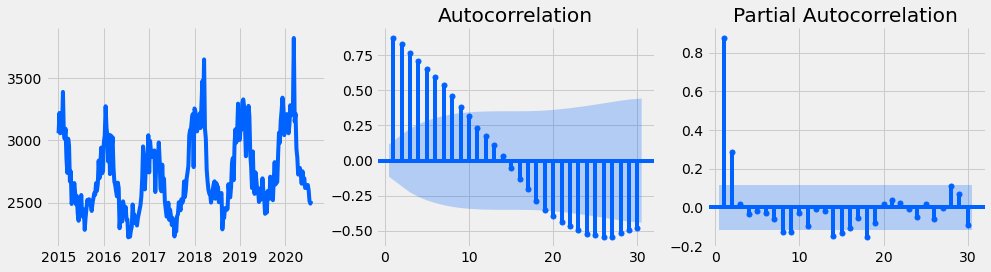

In [21]:
# plot for daily Consumption
plots(Gr_e_w.Consumption_MW, lags=30);

#### Observations.

- Autocorrelation Function Plot shows us a behavioral pattern, where autocorrelation values are alternating between positive and negative values, decaying to zero.

### SARIMA-ARIMA MODEL.

- ARIMA orders(p,d,q):
  - p is number od AR terms
  - d is number of times that we would difference our data
  - q is is number of MA terms
 
- Orders used (2,0,0) 

- SARIMA orders(P,D,Q):
  - P is number of AR terms in regards to seasonal lag
  - D is number of times that we would difference our seasonal lag
  - Q is number of MA terms in regards to seasonal lag
  - S is number of periods in a season
 
- Orders used (0,1,1) and S: 60 (weeks)

In [22]:
## Auto-ARIMA models 
stepwise_model = pm.auto_arima(Gr_e_w.Consumption_MW, start_p=1, start_q=1,
                               max_p=3, max_q=3, m=60,
                               start_P=0, seasonal=True,d= 0, 
                               D= 1, trace=True,
                               error_action='ignore',  
                               suppress_warnings=True, 
                               stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[60] intercept   : AIC=3060.131, Time=59.54 sec
 ARIMA(0,0,0)(0,1,0)[60] intercept   : AIC=3326.413, Time=0.41 sec
 ARIMA(1,0,0)(1,1,0)[60] intercept   : AIC=3083.775, Time=30.55 sec
 ARIMA(0,0,1)(0,1,1)[60] intercept   : AIC=3212.959, Time=29.48 sec
 ARIMA(0,0,0)(0,1,0)[60]             : AIC=3325.999, Time=0.50 sec
 ARIMA(1,0,1)(0,1,0)[60] intercept   : AIC=3097.257, Time=5.54 sec
 ARIMA(1,0,1)(1,1,1)[60] intercept   : AIC=inf, Time=64.12 sec
 ARIMA(1,0,1)(0,1,2)[60] intercept   : AIC=inf, Time=182.18 sec
 ARIMA(1,0,1)(1,1,0)[60] intercept   : AIC=3068.152, Time=27.69 sec
 ARIMA(1,0,1)(1,1,2)[60] intercept   : AIC=inf, Time=232.11 sec
 ARIMA(1,0,0)(0,1,1)[60] intercept   : AIC=3074.069, Time=47.39 sec
 ARIMA(2,0,1)(0,1,1)[60] intercept   : AIC=3057.748, Time=44.23 sec
 ARIMA(2,0,1)(0,1,0)[60] intercept   : AIC=3095.295, Time=10.88 sec
 ARIMA(2,0,1)(1,1,1)[60] intercept   : AIC=inf, Time=87.54 sec
 ARIMA(2,0,1)(0,1,2)[60] i

In [23]:
## Summary model
stepwise_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  291
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 60)   Log Likelihood               -1522.919
Date:                              Thu, 19 Aug 2021   AIC                           3055.837
Time:                                      20:14:03   BIC                           3073.050
Sample:                                           0   HQIC                          3062.780
                                              - 291                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     21.2176      8.802      2.411      0.016       3.967      38.469
ar.L1          0.5544      0.047     11.850      0.000       0.463       0.646
ar.L2          0.2844      0.048      5.937      0.000       0.191       0.378
ma.S.L60      -0.4977      0.091     -5.470      0.000      -0.676      -0.319
sigma2      2.704e+04   2570.925     10.516      0.000     2.2e+04    3.21e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.69   Jarque-Bera (JB):                 1.20
Prob(Q):                              0.41   Prob(JB):                         0.55
Heteroskedasticity (H):               1.24   Skew:                            -0.09
Prob(H) (two-sided):                  0.34   Kurtosis:                         3.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Plot residual diagnostics

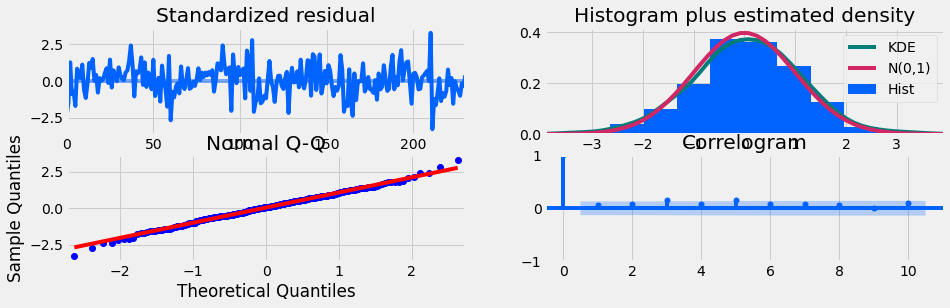

In [24]:
stepwise_model.plot_diagnostics();

## Observation.

**Top left**: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

**Top right**: The density plot suggest normal distribution with mean zero.

**Bottom left**: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

**Bottom Right**: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. 

### Forecast 

In [25]:
from dateutil.relativedelta import relativedelta
def future_preds_df(model,series,num_weeks):
    pred_first = series.index.max()+relativedelta(weeks=1)
    pred_last = series.index.max()+relativedelta(weeks=num_weeks)
    date_range_index = pd.date_range(pred_first,pred_last,freq = 'W')
    vals = model.predict(n_periods = num_weeks)
    return pd.DataFrame(vals,index = date_range_index)

In [26]:
preds = future_preds_df(stepwise_model,Gr_e_w.Consumption_MW,70)

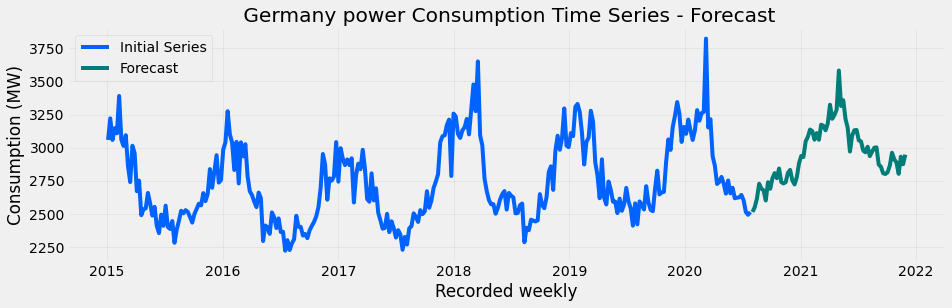

In [28]:
plt.plot(Gr_e_w.Consumption_MW,label='Initial Series')
plt.plot(preds,label='Forecast')
plt.title(' Germany power Consumption Time Series - Forecast')
plt.legend()
plt.xlabel('Recorded weekly')
plt.ylabel('Consumption (MW)')
plt.grid(alpha=0.3)

### Observations.
- According to the forecast, it's expected a progressive increase in weekly power consumption for early 2021, followed by a progressive decline (with small increases) until the end of that year.

Author: Luis Fernando Salazar Salinas.
Date:22/07/2021